# <font color='firebrick'>Problem Set \#2:</font> Due Tuesday, November 1, 2022

The banking industry has invested significantly in tools to improve banks' ability to predict loan default from observable (and legal) characteristics. The **objective** of this notebook is to develop a supervised learning model to predict loan default.

**This is a group problem set. You can and should work with your MSBA groups but again must turn in your own solutions.**

Answer the questions below. This notebook will be your workspace so add cells as you please. when you're done, submit your notebook as a pdf. [To print: From the file menu, choose 'print preview'. A new tab will open with the notebook presented as html. Print as a pdf.] Save your pdf notebook with the naming convention **'PS2_[insert last name]'**. For example, 'PS2_Thurk.pdf'. 

**Grading:** The problem set is worth **70 points** and partial credit is indicated for each exercise.

**A reminder:** My office hours are Wednesdays 3:00PM-5:00PM EDT and Friday via Zoom. See the syllabus for the Zoom link.

# Names: <font color= red>Daniel Saul</font>

# 1. Load Data <font color=brown>[10 Points]</font>

We will use the Berka Dataset which is a collection of real anonymized financial information from a Czech bank. On eLC is a zip-file containing 8 raw files:

* `account.asc` (4,500 observations) — each record describes static characteristics of an account.
* `client.asc` (5,369 observations) — each record describes characteristics of a client.
* `disp.asc` (5,369 observations) — each record relates a client with an account.
* `order.asc` (6,471 observations) — each record describes characteristics of credit card payment order.
* `transaction.asc` (1,056,320 observations) — each record describes a transaction for a given account.
* `loan.asc` (682 observations) — each record describes a loan granted for a given account.
* `card.asc` (892 observations) — each record describes a credit card issued to an account.
* `district.asc` (77 observations) — each record describes demographic characteristics of a district.

There is a lot of data here and we'll only use some of it (though you'll have the freedom to use more). Descriptions of individual variables are located in the `data_variables_xlsx` file. You can load the data using `read_csv` and note the data are delimited by a semi-colon.

The following image documents how the files connect:

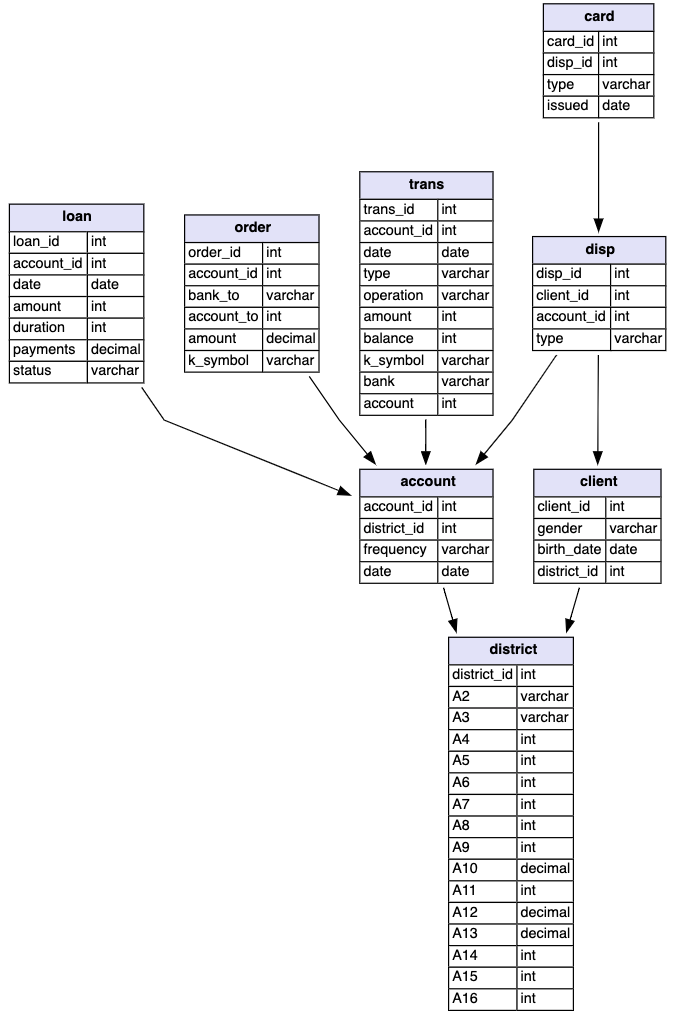

In [24]:
# import required packages
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score

# load asc file data
account = pd.read_csv('account.asc', sep=';')
client = pd.read_csv('client.asc', sep=';')
disp = pd.read_csv('disp.asc', sep=';')
order = pd.read_csv('order.asc', sep=';')
trans = pd.read_csv('trans.asc', sep=';', low_memory = False)
loan = pd.read_csv('loan.asc', sep=';')
card = pd.read_csv('card.asc', sep=';')
district = pd.read_csv('district.asc', sep=';')

# 2. Data Pre-processing and Feature Generation <font color=brown>[20 Points]</font>

Let's assemble our main DataFrame and create some additional variables. Initially, we will not incorporate all of the data but you will be free to do so.

## 2.1 Initialize the main dataframe:
* Start with `loan`
* Merge with `account` using variable `account_id`
* Merge new df with `district` using `district_id`

In [25]:
# merge loan with account
df = loan.merge(account, on='account_id')

# merge new df with district
district = district.rename({'A1':'district_id'}, axis=1)
main = df.merge(district, how='left', on='district_id')
main.head()

,loan_id,account_id,date_x,amount,duration,payments,status,district_id,frequency,date_y,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,5314,1787,930705,96396,12,8033.0,B,30,POPLATEK TYDNE,930322,...,8,2,10,81.8,9650,3.38,3.67,100,2985,2804
1,5316,1801,930711,165960,36,4610.0,A,46,POPLATEK MESICNE,930213,...,7,3,10,73.5,8369,1.79,2.31,117,2854,2618
2,6863,9188,930728,127080,60,2118.0,A,45,POPLATEK MESICNE,930208,...,6,1,5,53.5,8390,2.28,2.89,132,2080,2122
3,5325,1843,930803,105804,36,2939.0,A,12,POPLATEK MESICNE,930130,...,6,1,6,58.0,8754,3.83,4.31,137,3804,3868
4,7240,11013,930906,274740,60,4579.0,A,1,POPLATEK TYDNE,930214,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107


Clean the data:

* Convert dates to datetime
* Date in `account` is date of account creation. Date in `loan` is date loan is issued. Create a variable for days between account creation and loan issuance.
* Change variable "A4" to "Number of Inhabitants"
* Change variable "A11" to "Average Salary"
* Change variable 'A14' to "entrepreneuer rate"
* Create average unemployment rate by averaging "A12" and "A13"
* Create average crime rate by averaging "A15" and "A16" and then dividing by "Number of Inhabitants"

In [26]:
# rename date columns
main = main.rename({'date_x':'date_created', 'date_y':'date_issued'}, axis=1)

# change date columns to datetime format
main['date_created'] = pd.to_datetime(main['date_created'], format='%y%m%d')
main['date_issued'] = pd.to_datetime(main['date_issued'], format='%y%m%d')

# calculate days between account creationo and loan issuance
import datetime as dt
main['days_between'] = (main['date_created'] - main['date_issued']).dt.days

# change requested column names
main = main.rename({'A4':'Number of Inhabitants', 'A11':'Average Salary', 'A14':'entrepreneur rate'}, axis=1)

# create average unemployment rate column
main['A12'] = pd.to_numeric(main['A12'], errors='coerce')
main['avg_unemp'] = (main['A12'] + main['A13'])/2

# create average crime rate column
main['A15'] = pd.to_numeric(main['A15'], errors='coerce')
main['avg_crime'] = (main['A15'] + main['A16'])/2
main['avg_crime'] = main['avg_crime']/main['Number of Inhabitants']

main.head()

,loan_id,account_id,date_created,amount,duration,payments,status,district_id,frequency,date_issued,...,A10,Average Salary,A12,A13,entrepreneur rate,A15,A16,days_between,avg_unemp,avg_crime
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,...,81.8,9650,3.38,3.67,100,2985.0,2804,105,3.525,0.030529
1,5316,1801,1993-07-11,165960,36,4610.0,A,46,POPLATEK MESICNE,1993-02-13,...,73.5,8369,1.79,2.31,117,2854.0,2618,148,2.050,0.024275
2,6863,9188,1993-07-28,127080,60,2118.0,A,45,POPLATEK MESICNE,1993-02-08,...,53.5,8390,2.28,2.89,132,2080.0,2122,170,2.585,0.026965
3,5325,1843,1993-08-03,105804,36,2939.0,A,12,POPLATEK MESICNE,1993-01-30,...,58.0,8754,3.83,4.31,137,3804.0,3868,185,4.070,0.035561
4,7240,11013,1993-09-06,274740,60,4579.0,A,1,POPLATEK TYDNE,1993-02-14,...,100.0,12541,0.29,0.43,167,85677.0,99107,204,0.360,0.076677


## 2.2 Add average order amount from `order`:

* Compute average order amount by `account_id`
* Merge to main df

In [27]:
# compute average order amount by id
order = order.groupby('account_id', as_index=False)['amount'].mean()

# merge to main df
main = main.merge(order, how='left', on='account_id')
main = main.rename({'amount_x':'loan_amount', 'amount_y':'avg_order_amt'}, axis=1)
main.head()

,loan_id,account_id,date_created,loan_amount,duration,payments,status,district_id,frequency,date_issued,...,Average Salary,A12,A13,entrepreneur rate,A15,A16,days_between,avg_unemp,avg_crime,avg_order_amt
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,...,9650,3.38,3.67,100,2985.0,2804,105,3.525,0.030529,8033.200000
1,5316,1801,1993-07-11,165960,36,4610.0,A,46,POPLATEK MESICNE,1993-02-13,...,8369,1.79,2.31,117,2854.0,2618,148,2.050,0.024275,3288.000000
2,6863,9188,1993-07-28,127080,60,2118.0,A,45,POPLATEK MESICNE,1993-02-08,...,8390,2.28,2.89,132,2080.0,2122,170,2.585,0.026965,2647.825000
3,5325,1843,1993-08-03,105804,36,2939.0,A,12,POPLATEK MESICNE,1993-01-30,...,8754,3.83,4.31,137,3804.0,3868,185,4.070,0.035561,4966.350000
4,7240,11013,1993-09-06,274740,60,4579.0,A,1,POPLATEK TYDNE,1993-02-14,...,12541,0.29,0.43,167,85677.0,99107,204,0.360,0.076677,4944.666667


## 2.3 Add number of transactions from `transaction`:

* Compute total number of transactions by `account_id`
* Merge to main df

In [28]:
# Compute total number of transactions by id
trans = trans.groupby('account_id', as_index=False)['trans_id'].count()

# Merge to main df
main = main.merge(trans, how='left', on='account_id')
main = main.rename({'trans_id':'trans_tot'}, axis=1)
main.head()

,loan_id,account_id,date_created,loan_amount,duration,payments,status,district_id,frequency,date_issued,...,A12,A13,entrepreneur rate,A15,A16,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,...,3.38,3.67,100,2985.0,2804,105,3.525,0.030529,8033.200000,403
1,5316,1801,1993-07-11,165960,36,4610.0,A,46,POPLATEK MESICNE,1993-02-13,...,1.79,2.31,117,2854.0,2618,148,2.050,0.024275,3288.000000,633
2,6863,9188,1993-07-28,127080,60,2118.0,A,45,POPLATEK MESICNE,1993-02-08,...,2.28,2.89,132,2080.0,2122,170,2.585,0.026965,2647.825000,605
3,5325,1843,1993-08-03,105804,36,2939.0,A,12,POPLATEK MESICNE,1993-01-30,...,3.83,4.31,137,3804.0,3868,185,4.070,0.035561,4966.350000,462
4,7240,11013,1993-09-06,274740,60,4579.0,A,1,POPLATEK TYDNE,1993-02-14,...,0.29,0.43,167,85677.0,99107,204,0.360,0.076677,4944.666667,571


## 2.4 Add credit card type `card`:

* Link card `type` to account_id using `disp`
* Merge to main df

In [29]:
# Link card type to account_id using disp
c = card.merge(disp, on='disp_id')
c = c.rename({'type_y':'type_disp', 'type_x':'type_card'}, axis=1)
c = c.drop(['disp_id','client_id','type_disp', 'card_id', 'issued'], axis=1)

# merge to main df
main = main.merge(c, how='left', on='account_id')
main.head()

,loan_id,account_id,date_created,loan_amount,duration,payments,status,district_id,frequency,date_issued,...,A13,entrepreneur rate,A15,A16,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot,type_card
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,...,3.67,100,2985.0,2804,105,3.525,0.030529,8033.200000,403,NaN
1,5316,1801,1993-07-11,165960,36,4610.0,A,46,POPLATEK MESICNE,1993-02-13,...,2.31,117,2854.0,2618,148,2.050,0.024275,3288.000000,633,NaN
2,6863,9188,1993-07-28,127080,60,2118.0,A,45,POPLATEK MESICNE,1993-02-08,...,2.89,132,2080.0,2122,170,2.585,0.026965,2647.825000,605,NaN
3,5325,1843,1993-08-03,105804,36,2939.0,A,12,POPLATEK MESICNE,1993-01-30,...,4.31,137,3804.0,3868,185,4.070,0.035561,4966.350000,462,classic
4,7240,11013,1993-09-06,274740,60,4579.0,A,1,POPLATEK TYDNE,1993-02-14,...,0.43,167,85677.0,99107,204,0.360,0.076677,4944.666667,571,junior


## 2.5 Add characteristics of the `owner`:

* Create variable for owner's gender
* Use birth data and loan data to create account owner's age
* Create a a boolean that represents if the owner has the same district information as the account
* Merge df to main df using `account id`

In [30]:
# Create variable for owner's gender
client['birth_number'] = client['birth_number'].astype(str)
client['year'] = '19' + client['birth_number'].str[0:2]
client['month'] = client['birth_number'].str[2:4]
client['day'] = client['birth_number'].str[4:6]

client['year'] = pd.to_numeric(client['year'])
client['month'] = pd.to_numeric(client['month'])
client['day'] = pd.to_numeric(client['day'])

client['gender'] = np.where(client['month'] > 12, 'Female', 'Male')
client['month'] = np.where(client['month'] > 12, client['month'] - 50, client['month'])

# Use birth data and loan data to create account owner's birth date
client['birth_date'] = pd.to_datetime(client[['year', 'month', 'day']], format='%y%m%d')


# Create a a boolean that represents if the owner has the same district information as the account
client = client.rename({'district_id':'district_id_owner'}, axis=1)
client = client.merge(disp, how='left', on = 'client_id')

client = client.merge(account, how='left', on = 'account_id').drop_duplicates(subset="account_id")
client = client.rename({'district_id':'district_id_account'}, axis=1)
client['same_district'] = client['district_id_account'] == client['district_id_owner']

# merge owner df to main df
main = main.merge(client, how='left', on = 'account_id')

# Calculate owner age after merging
main['owner_age'] = round(((main['date_issued'] - main['birth_date']).dt.days)/365.242, 0)

In [31]:
# drop unnecessary variables
main = main.drop(['loan_id','account_id','date_created', 'district_id', 'frequency_x', 'date_issued', 'date', 'district_id_account', 'district_id_owner', 'disp_id', 'birth_date', 'type', 'A2', 'A3', 'A5', 'A6', 'A7', 'client_id', 'A8', 'A9', 'A10', 'A12', 'birth_number', 'year', 'month', 'day', 'A13', 'A15', 'A16'], axis=1)
main = main.rename({'frequency_y':'frequency'}, axis=1)
main.head()

,loan_amount,duration,payments,status,Number of Inhabitants,Average Salary,entrepreneur rate,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot,type_card,gender,frequency,same_district,owner_age
0,96396,12,8033.0,B,94812,9650,100,105,3.525,0.030529,8033.200000,403,NaN,Female,POPLATEK TYDNE,True,46.0
1,165960,36,4610.0,A,112709,8369,117,148,2.050,0.024275,3288.000000,633,NaN,Male,POPLATEK MESICNE,True,25.0
2,127080,60,2118.0,A,77917,8390,132,170,2.585,0.026965,2647.825000,605,NaN,Male,POPLATEK MESICNE,True,57.0
3,105804,36,2939.0,A,107870,8754,137,185,4.070,0.035561,4966.350000,462,classic,Female,POPLATEK MESICNE,False,53.0
4,274740,60,4579.0,A,1204953,12541,167,204,0.360,0.076677,4944.666667,571,junior,Male,POPLATEK TYDNE,False,14.0


## 2.6 Add load default status:

The `loan` file contains a status variable which will be helpful:

* "A" Contract finished, no problems.
* "B" Contract finished, loan not repaid.
* "C" Running contract, okay so far.
* "D" Running contract, client in debt.

Define A and C as being in "good" status. Define B and D as being in "Default". Create a new variable called "default" which indicates whether the loan is in good status or not.

In [32]:
# Define A and C as being in "good" status. Define B and D as being in "Default"
# Create a new variable called "default" which indicates whether the loan is in good status or not
main['default'] = np.where((main['status']=='A') | (main['status']=='C'), 'good', 'Default')
main = main.drop(['status'], axis=1)
main.head()

,loan_amount,duration,payments,Number of Inhabitants,Average Salary,entrepreneur rate,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot,type_card,gender,frequency,same_district,owner_age,default
0,96396,12,8033.0,94812,9650,100,105,3.525,0.030529,8033.200000,403,NaN,Female,POPLATEK TYDNE,True,46.0,Default
1,165960,36,4610.0,112709,8369,117,148,2.050,0.024275,3288.000000,633,NaN,Male,POPLATEK MESICNE,True,25.0,good
2,127080,60,2118.0,77917,8390,132,170,2.585,0.026965,2647.825000,605,NaN,Male,POPLATEK MESICNE,True,57.0,good
3,105804,36,2939.0,107870,8754,137,185,4.070,0.035561,4966.350000,462,classic,Female,POPLATEK MESICNE,False,53.0,good
4,274740,60,4579.0,1204953,12541,167,204,0.360,0.076677,4944.666667,571,junior,Male,POPLATEK TYDNE,False,14.0,good


In [33]:
# convert categorical columns to numerical
# frequency column
def convert_freq(x):
    if x == 'POPLATEK TYDNE':
        return 1
    if x == 'POPLATEK PO OBRATU':
        return 2
    if x == 'POPLATEK MESICNE':
        return 3
main.frequency = main.frequency.apply(convert_freq)

# gender column
def convert_gen(x):
    if x == 'Female':
        return 1
    if x == 'Male':
        return 0
main.gender = main.gender.apply(convert_gen)
main = main.rename({'gender':'female'}, axis=1)

# card type column
def convert_card(x):
    if x == 'classic':
        return 1
    if x == 'junior':
        return 2
    if x == 'gold':
        return 3
    else:
        return 4
main.type_card = main.type_card.apply(convert_card)

# card type column
def convert_dis(x):
    if x == True:
        return 1
    if x == False:
        return 0
main.same_district = main.same_district.apply(convert_dis)

# drop 8 null values
main = main.dropna()
main.head()

,loan_amount,duration,payments,Number of Inhabitants,Average Salary,entrepreneur rate,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot,type_card,female,frequency,same_district,owner_age,default
0,96396,12,8033.0,94812,9650,100,105,3.525,0.030529,8033.200000,403,4,1,1,1,46.0,Default
1,165960,36,4610.0,112709,8369,117,148,2.050,0.024275,3288.000000,633,4,0,3,1,25.0,good
2,127080,60,2118.0,77917,8390,132,170,2.585,0.026965,2647.825000,605,4,0,3,1,57.0,good
3,105804,36,2939.0,107870,8754,137,185,4.070,0.035561,4966.350000,462,1,1,3,0,53.0,good
4,274740,60,4579.0,1204953,12541,167,204,0.360,0.076677,4944.666667,571,2,0,1,0,14.0,good


In [34]:
main.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount,674.0,150331.317507,112542.870711,4980.000000,66534.000000,116268.000000,209148.000000,5.908200e+05
duration,674.0,36.480712,17.070619,12.000000,24.000000,36.000000,48.000000,6.000000e+01
payments,674.0,4164.951039,2208.048505,304.000000,2451.000000,3900.000000,5776.750000,9.910000e+03
Number of Inhabitants,674.0,274773.081602,359577.644597,45714.000000,93931.000000,124920.500000,226122.000000,1.204953e+06
Average Salary,674.0,9518.772997,1322.975192,8110.000000,8546.000000,8992.500000,9897.000000,1.254100e+04
entrepreneur rate,674.0,121.185460,23.502579,81.000000,105.000000,115.000000,134.250000,1.670000e+02
days_between,674.0,398.207715,164.340462,102.000000,261.250000,396.000000,528.750000,6.970000e+02
avg_unemp,674.0,3.189214,1.995513,0.360000,1.760000,3.045000,4.377500,8.370000e+00
avg_crime,674.0,0.036277,0.018287,0.014744,0.022194,0.031778,0.042703,7.667685e-02
avg_order_amt,674.0,4458.553361,2121.127197,312.000000,2780.225000,4174.558333,5831.262500,1.081700e+04


### <font color=red>Comments</font> 

Your final dataframe should have about 700 observations and include the following variables (your variable names can be different):

| Variable | Description |
|:-|:-|
| amount| Loan amount |
| duration| Loan duration |
| payments| Loan payments |
| days_between| Days between account creation and loan issuance |
| frequency| Frequency of issuance of statements |
| average_order_amount| Average amount of the permanent orders made by the account |
| average_trans_amount| Average amount of the transactions made by the account |
| average_trans_balance| Average balance amount after transactions made by the account |
| n_trans| Transaction number of account |
| card_type| Type of credit card associated with the account |
| n_inhabitants| Number of inhabitants in the district of account |
| average_salary| Average salary in the district of account |
| average_unemployment| Average unemployment rate in the district of account |
| entrepreneur_rate| Number of entrepreneurs per 1000 inhabitants in the district of account |
| average_crime_rate| Average crime rate in the district of account |
| owner_gender| Account owner's gender |
| owner_age| Account owner's age |
| same_district| A boolean that represents if the owner has the same district information as the account |

Below is a picture of the descriptive statistics for my dataframe. BTW if you find this picture a helpful check-point, thank Jack O'Donnell for the suggestion. If you don't find this helpful, forget it exists.
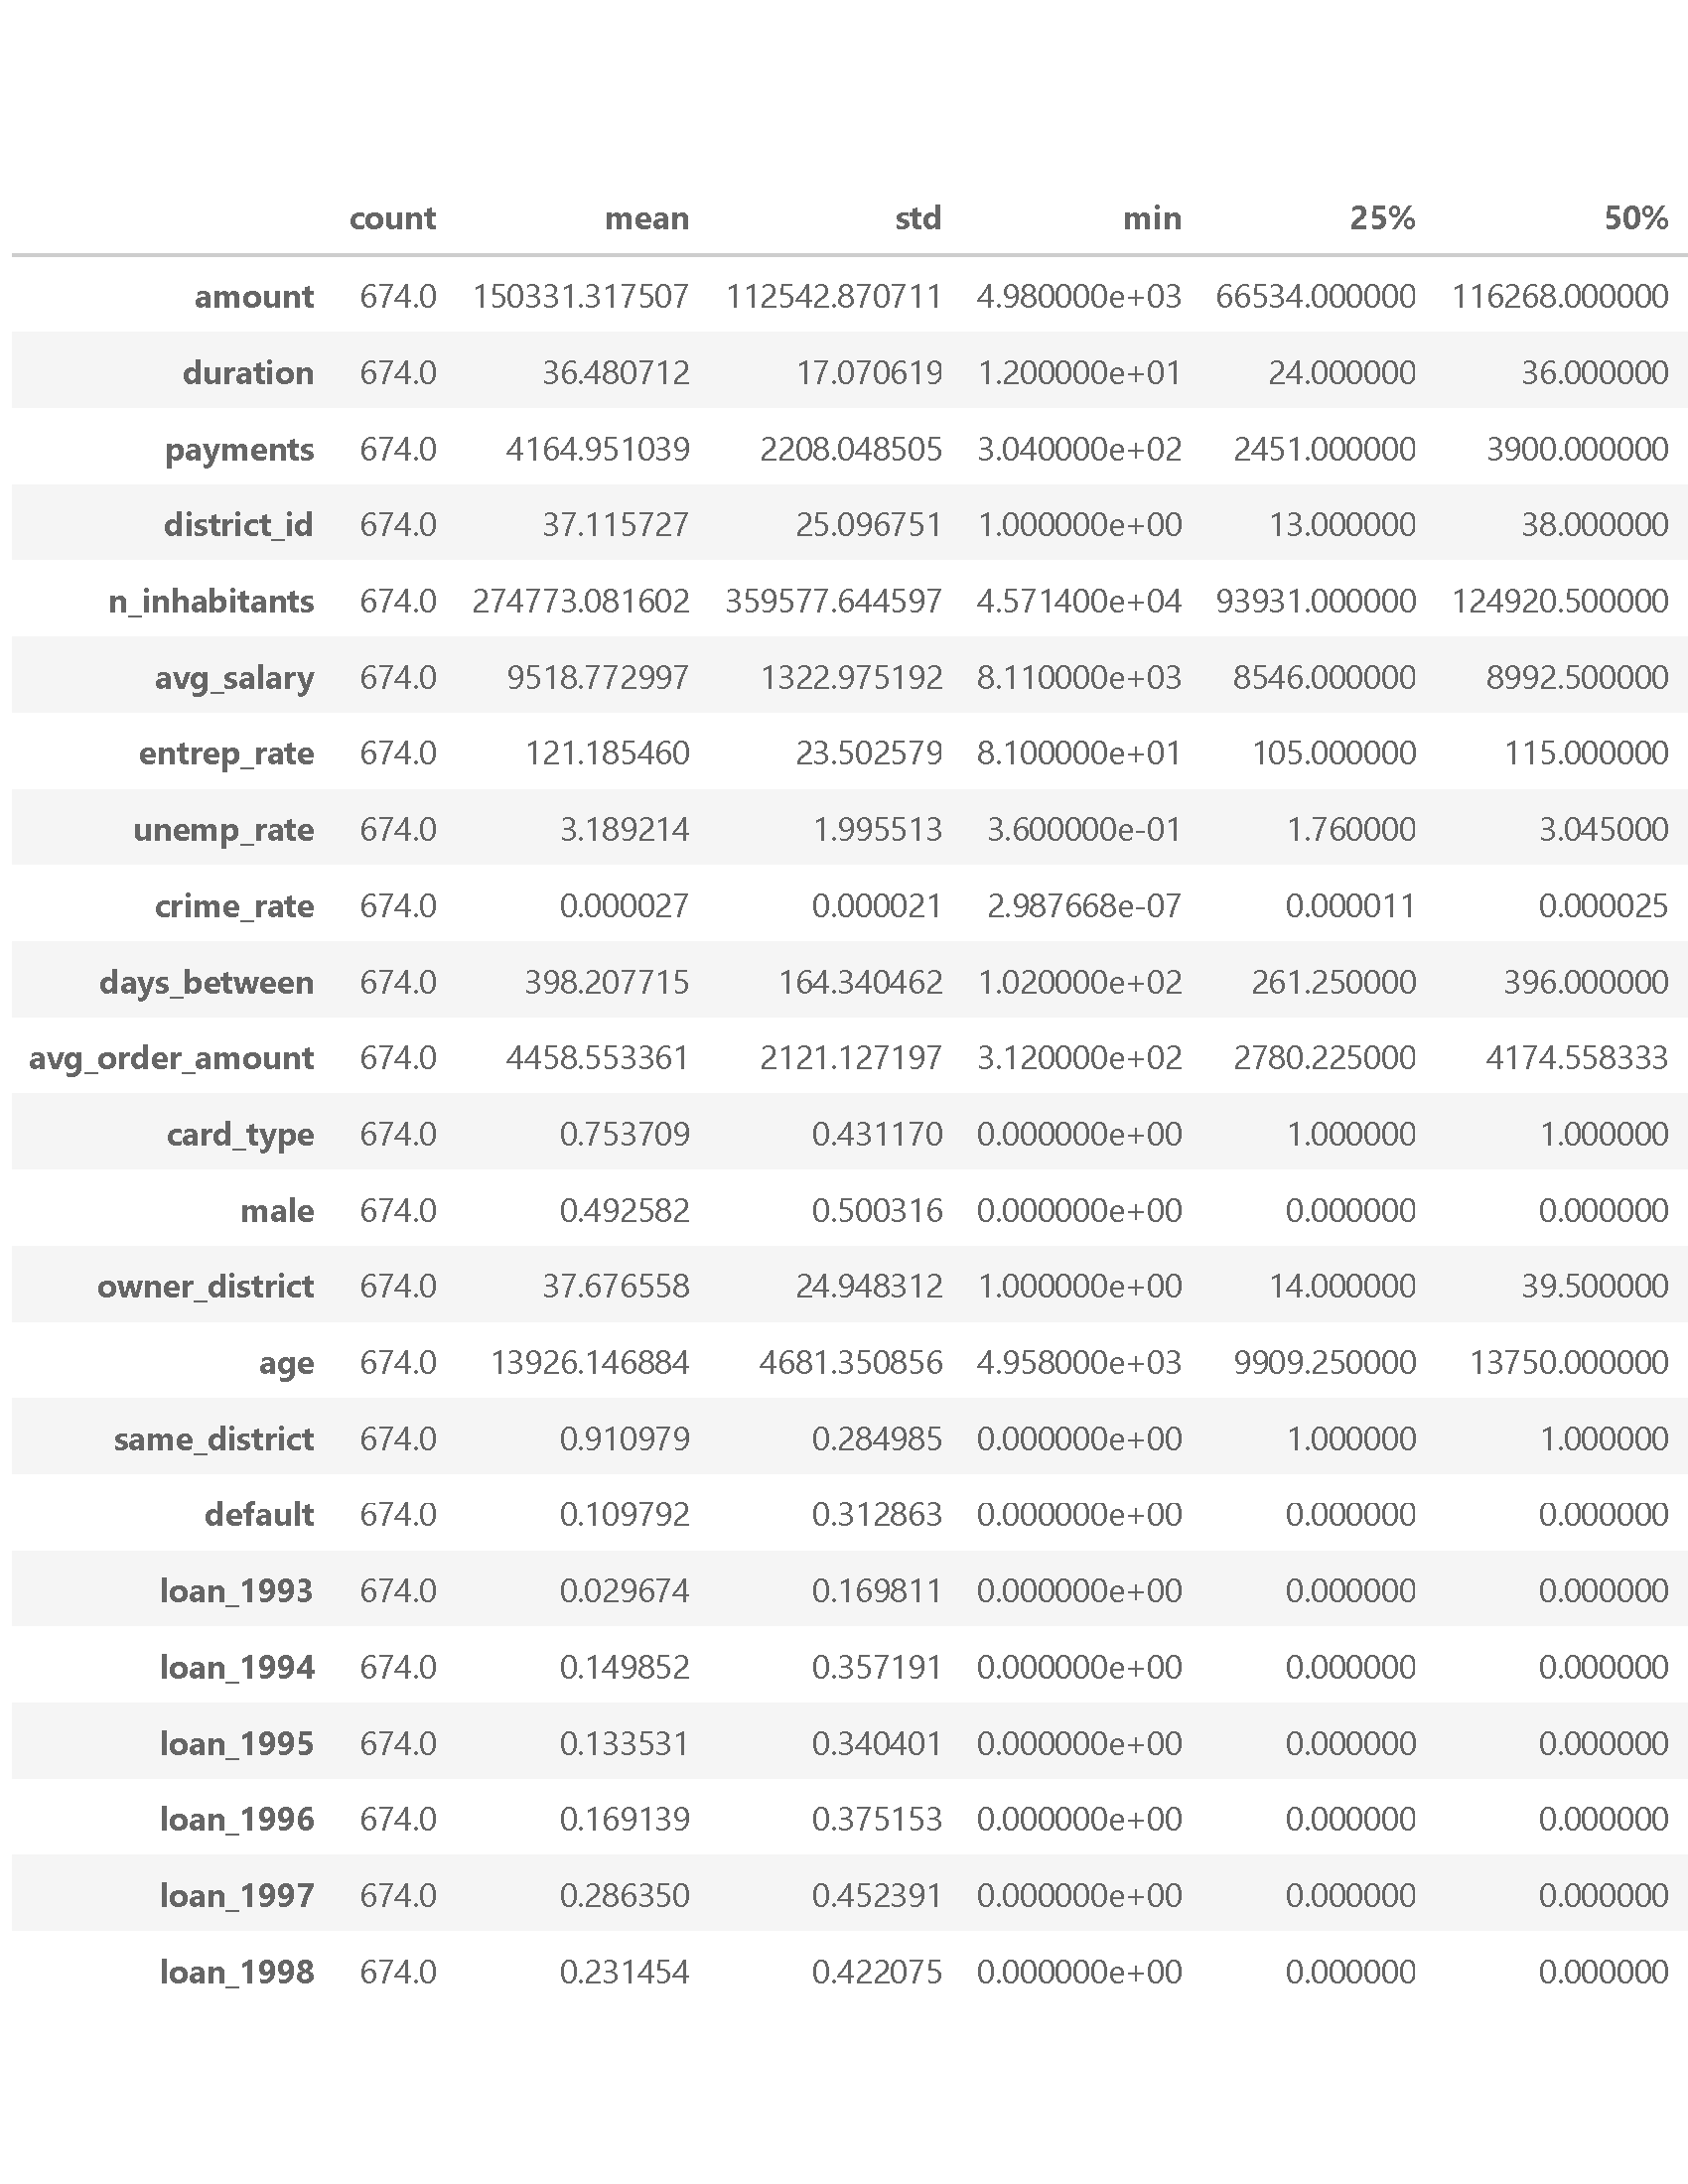

# 3. Exploratory Data Analysis <font color=brown>[20 Points]</font>

## 3.1 Compare Loan Amount and Default Status

* Create a histogram of loan amount for loans in good standing.
* Create a histogram of loan amount for loans in default standing.
* Put them side-by-side
* Add commentary.

Text(0.5, 1.0, 'Default Standing')

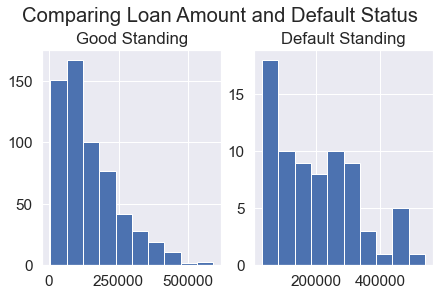

In [35]:
# Put them side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
fig.suptitle('Comparing Loan Amount and Default Status')

# Create a histogram of loan amount for loans in good standing.
ax1.hist(main[main.default == 'good'].loan_amount)

# Create a histogram of loan amount for loans in default standing.
ax2.hist(main[main.default == 'Default'].loan_amount)

ax1.set_title('Good Standing')
ax2.set_title('Default Standing')

In the "Good Standing" plot, we can see that a high number of loans are in good standing when the loan amount is on the lower side. In the "Default Standing" plot, we can see that loans in default standing tend to be associated with a higher loan amount. A larger count of the records in our dataset are in a good standing, in other words being more common, compared to those with designated as default standing.

## 3.2 Compare `days_between` and Default Status

* Create a histogram of days between loan issuance and account creation for loans in good standing.
* Create a histogram of days between loan issuance and account creation for loans in default standing.
* Put them side-by-side.
* Add commentary.

Text(0.5, 1.0, 'Default Standing')

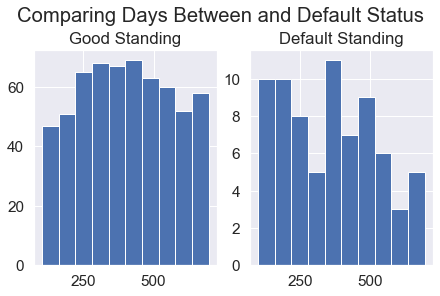

In [36]:
# Put them side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
fig.suptitle('Comparing Days Between and Default Status')

# Create a histogram of days between for loans in good standing.
ax1.hist(main[main.default == 'good'].days_between)

# Create a histogram of days between for loans in default standing.
ax2.hist(main[main.default == 'Default'].days_between)

ax1.set_title('Good Standing')
ax2.set_title('Default Standing')

In the "Good Standing" plot, the number of loans designated as good standing is larger as the number of days between loan issuance and account creation increases. In the "Default Standing" plot, the number of loans designated as default standing is larger as the number of days between loan issuance and account creation decreases. We observe that those who are more patient to get issued a loan after account creation are in a better standing than those who need a loan sooner.

# 4. Model Development <font color=brown>[20 Points]</font>

This is a binary classification problem so let's try using a Random Forest model to predict loan default.

### 4.1 Separate the Data into Training and Testing Sets

Set the `random_state=10` for comparability.

In [37]:
# drop dependent variable in dataset
x = main.drop('default', axis = 1)

# set y as dependent variable
y = main['default']

# split 20/80 testing and training data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=10)

### 4.2 Scale the Training and Testing Data

In [38]:
scaler = MinMaxScaler()

# scale the training data
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_train = pd.DataFrame(scaled_x_train, columns=x_train.columns, index=x_train.index)

# scale the testing data
scaled_x_test = scaler.fit_transform(x_test)
scaled_x_test = pd.DataFrame(scaled_x_test, columns=x_test.columns, index=x_test.index)

scaled_x_train.head()

,loan_amount,duration,payments,Number of Inhabitants,Average Salary,entrepreneur rate,days_between,avg_unemp,avg_crime,avg_order_amt,trans_tot,type_card,female,frequency,same_district,owner_age
97,0.232589,0.25,0.584827,0.049080,0.017378,0.151163,0.480672,0.596754,0.096870,0.266641,0.924920,0.0,0.0,1.0,1.0,0.375000
429,0.124314,0.00,0.647595,1.000000,1.000000,1.000000,0.025210,0.000000,1.000000,0.587501,0.151757,1.0,0.0,1.0,1.0,0.583333
464,0.295002,0.50,0.485696,0.043047,0.270142,0.430233,0.539496,0.471910,0.239491,0.440457,0.198083,1.0,1.0,1.0,1.0,0.250000
68,0.463744,0.50,0.773447,0.068054,0.149402,0.523256,0.356303,0.558677,0.151453,0.701856,0.546326,1.0,0.0,1.0,1.0,0.645833
680,0.086460,0.25,0.211045,0.206750,0.466486,0.000000,0.910924,0.852684,0.327312,0.190909,0.111821,1.0,0.0,1.0,1.0,0.729167


### 4.3. Fit a Random Forest model to the (scaled) training data. 

Set `n_estimators` to 100.

In [39]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(scaled_x_train, y_train)
y_pred = classifier.predict(scaled_x_test)

### 4.4 Use the Testing Data to Evaluate the Model Accuracy.

In [40]:
print(classification_report(y_test, y_pred))
print('The accuracy of the Random Forest is {0:4.2f}.'.format(metrics.accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

     Default       1.00      0.05      0.10        19
        good       0.87      1.00      0.93       116

    accuracy                           0.87       135
   macro avg       0.93      0.53      0.51       135
weighted avg       0.88      0.87      0.81       135

The accuracy of the Random Forest is 0.87.


### 4.5 Evaluate the Fit Using a `confusion_matrix`

Comment on the results of your final model in the report.

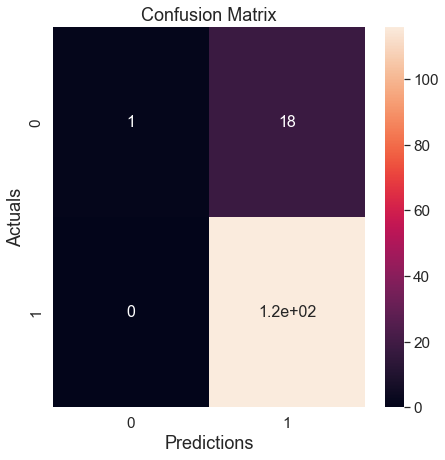

In [41]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, ax=ax,annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### 4.6. Visualize feature importance. Are there any features (variables) we can exclude?

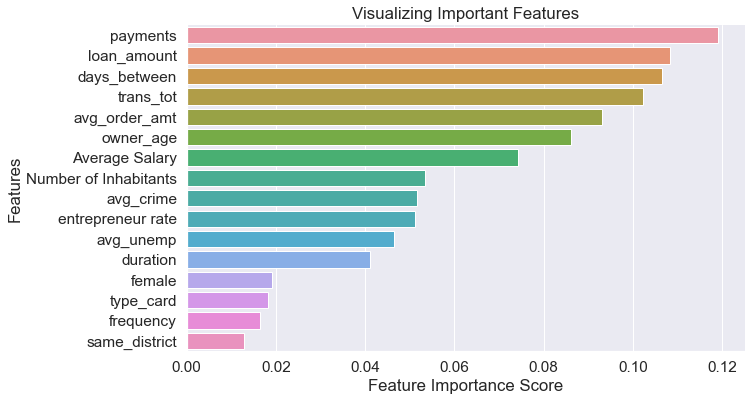

In [42]:
feature_imp = pd.Series(classifier.feature_importances_, index=['loan_amount', 'duration', 'payments', 'Number of Inhabitants', 'Average Salary', 'entrepreneur rate', 'days_between', 'avg_unemp', 'avg_crime', 'avg_order_amt', 'trans_tot', 'type_card', 'female','frequency', 'same_district', 'owner_age']).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
sns.despine()

plt.show()

Yes, it looks like we should exclude owner_age, same_district, frequency, and female (gender) because they have low variable importance scores.

### 4.7 Improve the Model. 

* Remove less important features. Your choice.<br><br>
* Use a different `n_estimator` value when fitting the Random Forest. Try looping through different values and plot the accuracy scores achieved across fitted models.<br><br>NB, There's a subtle point here that random forest models are thought to not require cross-validation because they inherently do it inside the algorithm to construct the best model. That said, we can still tune the model as demonstrated here. It's just that we don't have to be explicit about the k-folds.

Text(0, 0.5, 'Testing Accuracy')

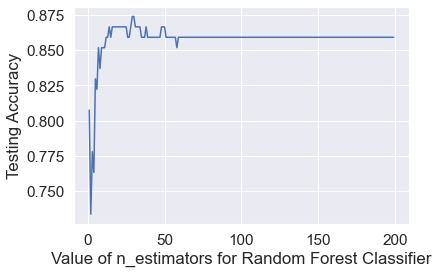

In [43]:
# remove less important features from training and testing x data
scaled_x_train = scaled_x_train.drop(['type_card','same_district','frequency', 'female'], axis=1)
scaled_x_test = scaled_x_test.drop(['type_card','same_district','frequency', 'female'], axis=1)

scores =[]
for k in range(1, 200):
    rfc = RandomForestClassifier(n_estimators=k, random_state=0)
    rfc.fit(scaled_x_train, y_train)
    y_pred = rfc.predict(scaled_x_test)
    scores.append(accuracy_score(y_test, y_pred))

# plot the relationship between K and testing accuracy
plt.plot(range(1, 200), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [45]:
# find best n_estimator with max accuracy score
max_accuracy_score = max(scores)
max_index = scores.index(max_accuracy_score)
print(f"The highest accuracy score is: {round(max_accuracy_score, 4)} with n_estimators set to: {max_index}")

The highest accuracy score is: 0.8741 with n_estimators set to: 28


              precision    recall  f1-score   support

     Default       0.67      0.11      0.18        19
        good       0.87      0.99      0.93       116

    accuracy                           0.87       135
   macro avg       0.77      0.55      0.55       135
weighted avg       0.84      0.87      0.82       135

The accuracy of the Random Forest is 0.87.


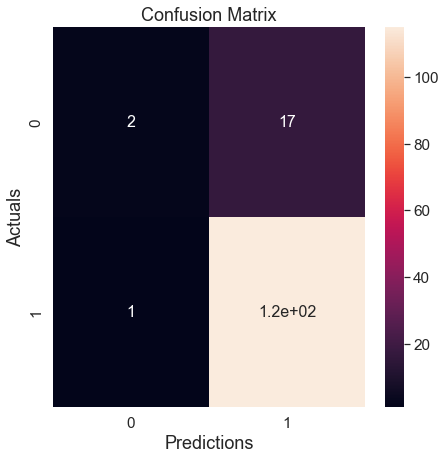

In [46]:
# final model
rfc = RandomForestClassifier(n_estimators=28, random_state=0)
rfc.fit(scaled_x_train, y_train)
y_pred = rfc.predict(scaled_x_test)

# use testing data to evaluate model accuracy
print(classification_report(y_test, y_pred))
print('The accuracy of the Random Forest is {0:4.2f}.'.format(metrics.accuracy_score(y_test, y_pred)))

# evaluate fit using
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, ax=ax,annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Above, the final model accuracy score and confusion matrix is given. After removing the least important variables: owner_age, same_district, frequency, and female (gender), I looped through 200 estimator values while fitting the Random Forest. It was determined that when n_estimator is set to 28, it yields the highest accuracy score of 0.8741, a 0.0041 increase from my original model accuracy of 0.87. The confusion matrix shows that the model correctly predicts 122 cases of loan defaulting, with 2 true negatives and 120 true positives. Furthermore, it shows that there are 17 false positives which is a Type I Error and 1 false negative which is a Type II Error. With regards to errors, this model seems to predict a loan to default when it actually did not (17 cases).